# Targeted protein quantification from list of targets generated in R
needed to use R for peptide-to-protein mapping, jump back here to do quant because it is much faster

### All files needed for quant are on github at:
DI2A/data/targeted_quant

In [1]:
from pyteomics import mgf
from pyteomics import mzxml
from pyteomics import mass

import pandas as pd
import numpy as np
import re
import pickle
import timeit
import time
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.metrics import r2_score

from scipy.stats import ttest_ind, spearmanr

### Functions to match intensities, m/z, and to get quant frags from the target table

In [2]:
# to extract the int values between two other values
def getFragInt(pred_mass, mz_list, int_list, tol, tol_type):
    ''' 
    PURPOSE:
    Find observed intensity for theoretical m/z value in spectra
    
    INPUTS:
    pred_mass = the theoretical mass of the fragment ion
    mz_array = numpy array of all peak masses in the spectra
    int_array = numpy array of all peak intensities in the spectra
    ppm = the mass tolerance for the fragments in ppm
    noiselevel = value to be subtracted from each value
    
    OUTPUTS:
    numpy array containing the intensity for any m/z found
    
    '''
    if tol_type=="ppm":
        lowmz = pred_mass - pred_mass*tol
        highmz = pred_mass + pred_mass*tol
    if tol_type == "abs":
        lowmz = pred_mass - tol
        highmz = pred_mass + tol
    found = [int_list[index] for index, value in enumerate(mz_list) if value>lowmz and value<highmz]
    #found = found-noiselevel
    if len(found)==0:
        found = [1]
    return(found[0])

In [3]:
# function to get the quant frag table from the line in the target table
def getQuantFragsFromTargetList(target_table, line):
    tmpline = target_table.iloc[line]
    if(len(tmpline['ylight'])>1):
        output= pd.DataFrame( {'lightmz':[float(x) for x in tmpline['ylight']], 
                   'heavymz':[float(x) for x in tmpline['yheavy']]})
    if(len(tmpline['ylight'])<2):
        print(str(tmpline['Peptide'])+'not enough fragments')
        output = 'not enough fragments'
    return(output)

# For most intense peptide set - need to match peptide targets to scans

### Import the quant target table from R

In [4]:
qtargs2 = pd.read_csv("P:/JGM_DI2A/R/outputs/MITO_mostintense_quantmzlist.txt", sep="\t",
                          converters={"ylight": lambda x: x.strip("[]").split(", "),
                                     "yheavy": lambda x: x.strip("[]").split(", "), 
                                     "yordinals": lambda x: x.strip("[]").split(", ")})

In [5]:
target_scan_ids = [(qtargs2['prec_light_mz'][x], qtargs2['prec_heavy_mz'][x], qtargs2['CV'][x]) for x in range(len(qtargs2))]

In [6]:
len(target_scan_ids)

531

In [9]:
qtargs2.head()

,Protein,Peptide,prec_light_mz,prec_heavy_mz,z,scan,ylight,yheavy,yordinals,CV
0,"sp|P63261|ACTG_HUMAN Actin, cytoplasmic 2 OS=H...",E+42.01057EEIAALVIDNGSGMC+57.0215K,940.43,944.44,2,1,"[495.2054, 639.2589]","[503.2196, 647.2731]","[4, 6]",-30
1,"sp|P60709|ACTB_HUMAN Actin, cytoplasmic 1 OS=H...",D+42.01057DDIAALVVDNGSGMC+57.0215K,911.41,915.42,2,2,"[495.2054, 639.2589]","[503.2196, 647.2731]","[4, 6]",-30
2,sp|Q00341|VIGLN_HUMAN Vigilin OS=Homo sapiens ...,S+42.01057SVAVLTQESFAEHR,851.92,856.92,2,3,"[1104.5069, 1003.4592, 312.1779]","[1114.5151, 1013.4675, 322.1861]","[9, 8, 2]",-30
3,sp|Q8WVM8|SCFD1_HUMAN Sec1 family domain-conta...,A+42.01057AAAAATAAAAASIR,650.36,655.36,2,4,"[902.5054, 831.4683, 659.3835]","[912.5137, 841.4766, 669.3918]","[10, 9, 7]",-30
4,"sp|Q4G0N4|NAKD2_HUMAN NAD kinase 2, mitochondr...",VATQAVEDVLNIAK,735.91,739.92,2,5,"[1071.6045, 1000.5673, 901.4989]","[1079.6187, 1008.5815, 909.5131]","[10, 9, 8]",-30


In [7]:
[x for x in qtargs2['ylight'] if len(x)==1]

[['274.1874'], [''], ['232.1404'], ['335.1496'], [''], ['']]

In [10]:
### makes a dict of scan:CV value pairs for lookup of the CV
# pick any of the quant files
tmp_prec_dict = {}
with mzxml.read("P:/JGM_DI2A/MSDATA/20191112_DI2A_mito/20191112_DI2A_mito121_targeted_1iso240k_mostint_01.mzXML") as spectra:
    for x in spectra:
        tmp_prec_dict[round(x['precursorMz'][0]['precursorMz'], 2), 
                                   round(x['precursorMz'][1]['precursorMz'], 2), 
                                  x['compensationVoltage']] = x['num']

In [11]:
## fix the numbering of which scan each peptide should be quantified from because the table in case the table has decoys
quant_scan = []
for x in target_scan_ids:
    quant_scan.append(tmp_prec_dict[(x)])
qtargs2['quantscan'] = quant_scan

# Require both peaks

## 240k purified mitochondria experiment

In [95]:
fileslist = [
    "20191112_DI2A_mito121_targeted_1iso240k_mostint_01.mzXML",
    "20191112_DI2A_mito122_targeted_1iso240k_mostint_01.mzXML",
    "20191112_DI2A_mito123_targeted_1iso240k_mostint_01.mzXML",
    "20191112_DI2A_mito124_targeted_1iso240k_mostint_01.mzXML",
    "20191112_DI2A_mito125_targeted_1iso240k_mostint_01.mzXML",
    "20191112_DI2A_mito126_targeted_1iso240k_mostint_01.mzXML"
]

In [96]:
resultsdict = {}
stt = time.time()
TOL_TYPE = "ppm"
TOL = 10e-6
mypath = "P:/JGM_DI2A/MSDATA/20191112_DI2A_mito/"
resultsdf = pd.DataFrame(index=qtargs2['Protein'])
MIN_FRAGS = 3


for k in fileslist:
    meanratio_list = []
    medianratio_list= []
    matchdf_list = []
    quantscans = qtargs2['quantscan']
    with mzxml.read(mypath+k, use_index =True) as tmpquantfile:
        #quantscans = sortedpepdf['quantscans'].tolist()
        peplist = qtargs2['Peptide'].tolist()
        #specnamelist = sortedpepdf['Name'].tolist()
        looplen = len(qtargs2)
        st = time.time()
        for i in range(0, looplen):
            #print(i)
            #sts = time.time()
            tmp_qf = getQuantFragsFromTargetList(qtargs2, i)
            if(type(tmp_qf)==str):
                medianratio_list.append('NaN')
                meanratio_list.append('NaN')
            if(type(tmp_qf)!=str):
                tmpmzarray = tmpquantfile.get_by_id(quantscans[i])['m/z array'].tolist()
                tmpintarray = tmpquantfile.get_by_id(quantscans[i])['intensity array'].tolist()
                noiselvl = np.mean(sorted(tmpintarray)[0:9])
                lightints = [getFragInt(x, tmpmzarray, tmpintarray, TOL, TOL_TYPE) for x in tmp_qf['lightmz']]
                heavyints = [getFragInt(x, tmpmzarray, tmpintarray, TOL, TOL_TYPE) for x in tmp_qf['heavymz']]
                ratios = [x/y for x,y in zip(heavyints, lightints)]
                tmp_qf['lightint'] = lightints
                tmp_qf['heavyint'] = heavyints
                tmp_qf['HLratios'] = ratios
                matchdf_list.append(tmp_qf)
                
                # if either value is 1, delete both values
                # need to start at end of list or it deletes the value and list becomes too small to check next iter
                for x in reversed(range(0, len(heavyints))):
                    if heavyints[x]==1 or lightints[x]==1:
                        del lightints[x]
                        del heavyints[x]
                # take ratio of heavy/light
                rm0ratios = [x/y for x,y in zip( lightints, heavyints)]
                
                
                # if there is at least one fragment matched, compute ratio and append to lists
                if len(rm0ratios)>=MIN_FRAGS:
                    meanratio_list.append(np.log2(np.mean(rm0ratios)))
                    medianratio_list.append(np.log2(np.median(rm0ratios)))
                if len(rm0ratios)<MIN_FRAGS:
                    medianratio_list.append('NaN')
                    meanratio_list.append('NaN')
                #print('time for 1 spec= '+str(time.time()-sts))
        print('file= '+k+', quantified '+str(looplen/(time.time()-st))+' spectra per second')
    print(k.replace('20191112_DI2A_','').replace('_targeted_2iso_mostint_01.mzXML',''))
    resultsdf[k.replace('20191112_DI2A_','').replace('_targeted_2iso_mostint_01.mzXML','')] = medianratio_list
    
    resultsdict[k] = [matchdf_list, medianratio_list, meanratio_list]
print(time.time()-stt)

LDALEIAC+57.0215EVRnot enough fragments
IDVEDILC+57.0215Knot enough fragments
DIVENIC+57.0215GRnot enough fragments
NIDINDVTPNC+57.0215Rnot enough fragments
VELAAEC+57.0215C+57.0215Rnot enough fragments
TEAVAIMC+57.0215Knot enough fragments
file= 20191112_DI2A_mito121_targeted_1iso240k_mostint_01.mzXML, quantified 260.2506276722666 spectra per second
mito121_targeted_1iso240k_mostint_01.mzXML
LDALEIAC+57.0215EVRnot enough fragments
IDVEDILC+57.0215Knot enough fragments
DIVENIC+57.0215GRnot enough fragments
NIDINDVTPNC+57.0215Rnot enough fragments
VELAAEC+57.0215C+57.0215Rnot enough fragments
TEAVAIMC+57.0215Knot enough fragments
file= 20191112_DI2A_mito122_targeted_1iso240k_mostint_01.mzXML, quantified 264.2582526442135 spectra per second
mito122_targeted_1iso240k_mostint_01.mzXML
LDALEIAC+57.0215EVRnot enough fragments
IDVEDILC+57.0215Knot enough fragments
DIVENIC+57.0215GRnot enough fragments
NIDINDVTPNC+57.0215Rnot enough fragments
VELAAEC+57.0215C+57.0215Rnot enough fragments
TEAVA

In [97]:
df240 = resultsdf.apply (pd.to_numeric, errors='coerce')
#df240['Peptide'] = qtargs2['Peptide']
df240 = df240.dropna()
df240

,mito121_targeted_1iso240k_mostint_01.mzXML,mito122_targeted_1iso240k_mostint_01.mzXML,mito123_targeted_1iso240k_mostint_01.mzXML,mito124_targeted_1iso240k_mostint_01.mzXML,mito125_targeted_1iso240k_mostint_01.mzXML,mito126_targeted_1iso240k_mostint_01.mzXML
Protein,,,,,,
sp|Q8WVM8|SCFD1_HUMAN Sec1 family domain-containing protein 1 OS=Homo sapiens OX=9606 GN=SCFD1 PE=1 SV=4,0.621899,0.812120,0.960463,0.449424,1.434485,1.893385
"sp|P20674|COX5A_HUMAN Cytochrome c oxidase subunit 5A, mitochondrial OS=Homo sapiens OX=9606 GN=COX5A PE=1 SV=2",0.930869,1.433395,1.646109,1.072225,1.126720,2.100397
sp|P09874|PARP1_HUMAN Poly [ADP-ribose] polymerase 1 OS=Homo sapiens OX=9606 GN=PARP1 PE=1 SV=4,-0.949856,0.052858,0.669036,-1.230822,2.140713,1.885864
"sp|Q96A35|RM24_HUMAN 39S ribosomal protein L24, mitochondrial OS=Homo sapiens OX=9606 GN=MRPL24 PE=1 SV=1",0.343304,1.105856,0.678051,-0.405727,0.278884,1.060528
"sp|P25705|ATPA_HUMAN ATP synthase subunit alpha, mitochondrial OS=Homo sapiens OX=9606 GN=ATP5F1A PE=1 SV=1",0.401157,1.022360,1.301175,0.098876,0.809569,1.849226
"sp|P24752|THIL_HUMAN Acetyl-CoA acetyltransferase, mitochondrial OS=Homo sapiens OX=9606 GN=ACAT1 PE=1 SV=1",0.718243,1.121985,1.472411,0.125956,1.016733,1.922491
sp|P23396|RS3_HUMAN 40S ribosomal protein S3 OS=Homo sapiens OX=9606 GN=RPS3 PE=1 SV=2,0.614484,1.231521,1.596796,0.945764,1.929722,2.968754
"sp|P36776|LONM_HUMAN Lon protease homolog, mitochondrial OS=Homo sapiens OX=9606 GN=LONP1 PE=1 SV=2",0.466638,1.268101,1.212441,0.232286,1.579074,1.947908
sp|O00483|NDUA4_HUMAN Cytochrome c oxidase subunit NDUFA4 OS=Homo sapiens OX=9606 GN=NDUFA4 PE=1 SV=1,0.227731,1.318998,1.095870,0.202348,1.317261,1.872004


In [98]:
len(df240)

351

In [99]:
from sklearn.preprocessing import StandardScaler
scaler240 = StandardScaler(with_std=False)
scaled240 = scaler240.fit_transform(df240)
df240_scale = pd.DataFrame(scaled240 , index=df240.index, columns=newnames)
dfnp240_scale = df240_scale.to_numpy()
dfnp240 = df240.to_numpy()

## plot the ratio distributions before and after scaling to center

(-6, 6)

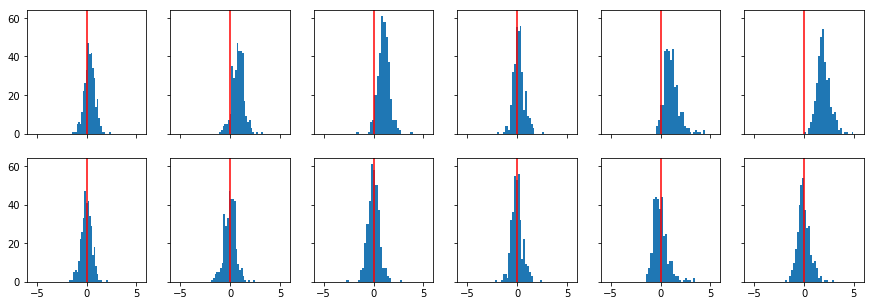

In [100]:

rcParams['figure.figsize'] = 15, 5
fig, [[ax1, ax2, ax3, ax4, ax5, ax6], [ax7, ax8, ax9, ax10, ax11, ax12]]= plt.subplots(2,6, sharex='all', sharey='all')
ax1.hist(dfnp240[:,0], bins=25)
ax1.axvline(x=0, color='r')
ax2.hist(dfnp240[:,1], bins=25)
ax2.axvline(x=0, color='r')
ax3.hist(dfnp240[:,2], bins=25)
ax3.axvline(x=0, color='r')
ax4.hist(dfnp240[:,3], bins=25)
ax4.axvline(x=0, color='r')
ax5.hist(dfnp240[:,4], bins=25)
ax5.axvline(x=0, color='r')
ax6.hist(dfnp240[:,5], bins=25)
ax6.axvline(x=0, color='r')
ax1.set_xlim(-6,6)


ax7.hist(dfnp240_scale[:,0], bins=25)
ax7.axvline(x=0, color='r')
ax8.hist(dfnp240_scale[:,1], bins=25)
ax8.axvline(x=0, color='r')
ax9.hist(dfnp240_scale[:,2], bins=25)
ax9.axvline(x=0, color='r')
ax10.hist(dfnp240_scale[:,3], bins=25)
ax10.axvline(x=0, color='r')
ax11.hist(dfnp240_scale[:,4], bins=25)
ax11.axvline(x=0, color='r')
ax12.hist(dfnp240_scale[:,5], bins=25)
ax12.axvline(x=0, color='r')
ax1.set_xlim(-6,6)

In [101]:
df240.columns=newnames

In [102]:
df240.head()

,WT_1,WT_2,WT_3,PPTC7_1,PPTC7_2,PPTC7_3
Protein,,,,,,
sp|Q8WVM8|SCFD1_HUMAN Sec1 family domain-containing protein 1 OS=Homo sapiens OX=9606 GN=SCFD1 PE=1 SV=4,0.621899,0.812120,0.960463,0.449424,1.434485,1.893385
"sp|P20674|COX5A_HUMAN Cytochrome c oxidase subunit 5A, mitochondrial OS=Homo sapiens OX=9606 GN=COX5A PE=1 SV=2",0.930869,1.433395,1.646109,1.072225,1.126720,2.100397
sp|P09874|PARP1_HUMAN Poly [ADP-ribose] polymerase 1 OS=Homo sapiens OX=9606 GN=PARP1 PE=1 SV=4,-0.949856,0.052858,0.669036,-1.230822,2.140713,1.885864
"sp|Q96A35|RM24_HUMAN 39S ribosomal protein L24, mitochondrial OS=Homo sapiens OX=9606 GN=MRPL24 PE=1 SV=1",0.343304,1.105856,0.678051,-0.405727,0.278884,1.060528
"sp|P25705|ATPA_HUMAN ATP synthase subunit alpha, mitochondrial OS=Homo sapiens OX=9606 GN=ATP5F1A PE=1 SV=1",0.401157,1.022360,1.301175,0.098876,0.809569,1.849226


In [113]:
df240_scale.head()

,WT_1,WT_2,WT_3,PPTC7_1,PPTC7_2,PPTC7_3,raw_pvals
Protein,,,,,,,
sp|Q8WVM8|SCFD1_HUMAN Sec1 family domain-containing protein 1 OS=Homo sapiens OX=9606 GN=SCFD1 PE=1 SV=4,0.313720,0.013140,-0.063136,0.274077,0.369710,-0.038046,0.535754
"sp|P20674|COX5A_HUMAN Cytochrome c oxidase subunit 5A, mitochondrial OS=Homo sapiens OX=9606 GN=COX5A PE=1 SV=2",0.622690,0.634415,0.622509,0.896878,0.061945,0.168966,0.393515
sp|P09874|PARP1_HUMAN Poly [ADP-ribose] polymerase 1 OS=Homo sapiens OX=9606 GN=PARP1 PE=1 SV=4,-1.258035,-0.746122,-0.354564,-1.406169,1.075938,-0.045568,0.435658
"sp|Q96A35|RM24_HUMAN 39S ribosomal protein L24, mitochondrial OS=Homo sapiens OX=9606 GN=MRPL24 PE=1 SV=1",0.035124,0.306876,-0.345549,-0.581074,-0.785891,-0.870904,0.023100
"sp|P25705|ATPA_HUMAN ATP synthase subunit alpha, mitochondrial OS=Homo sapiens OX=9606 GN=ATP5F1A PE=1 SV=1",0.092978,0.223380,0.277576,-0.076470,-0.255206,-0.082205,0.013851


(array([95., 26., 30., 19., 24., 18., 14., 13., 15.,  8.,  9.,  9.,  6.,
        11., 14.,  4.,  7., 16.,  6.,  7.]),
 array([9.75716050e-05, 5.00675734e-02, 1.00037575e-01, 1.50007577e-01,
        1.99977579e-01, 2.49947580e-01, 2.99917582e-01, 3.49887584e-01,
        3.99857586e-01, 4.49827587e-01, 4.99797589e-01, 5.49767591e-01,
        5.99737593e-01, 6.49707595e-01, 6.99677596e-01, 7.49647598e-01,
        7.99617600e-01, 8.49587602e-01, 8.99557603e-01, 9.49527605e-01,
        9.99497607e-01]),
 <a list of 20 Patch objects>)

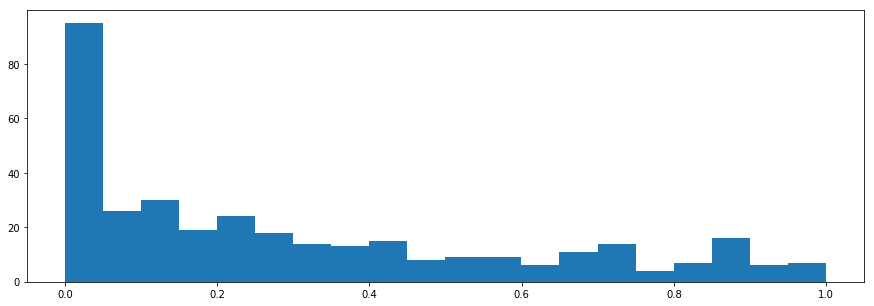

In [111]:
pvals = []
for i in range(0, len(df240_scale)):
    pvals.append(ttest_ind(df240_scale[wt_cols].iloc[i], df240_scale[pptc7_cols].iloc[i],equal_var=True)[1])
df240_scale['raw_pvals'] = pvals
plt.hist(df240_scale['raw_pvals'], bins=20)

In [107]:
testcorrection = multipletests(df240_scale['raw_pvals'], 0.05, 'fdr_bh')
defaultcor = multipletests(df240_scale['raw_pvals'], 0.05)


In [108]:
testcorrection

(array([False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False,
      

(array([ 5., 57., 23., 19., 13., 18., 21., 14., 31., 17., 16., 19.,  8.,
         7., 13., 12., 18.,  4., 29.,  7.]),
 array([0.023257  , 0.07206903, 0.12088106, 0.16969309, 0.21850512,
        0.26731715, 0.31612918, 0.36494121, 0.41375324, 0.46256527,
        0.5113773 , 0.56018933, 0.60900136, 0.6578134 , 0.70662543,
        0.75543746, 0.80424949, 0.85306152, 0.90187355, 0.95068558,
        0.99949761]),
 <a list of 20 Patch objects>)

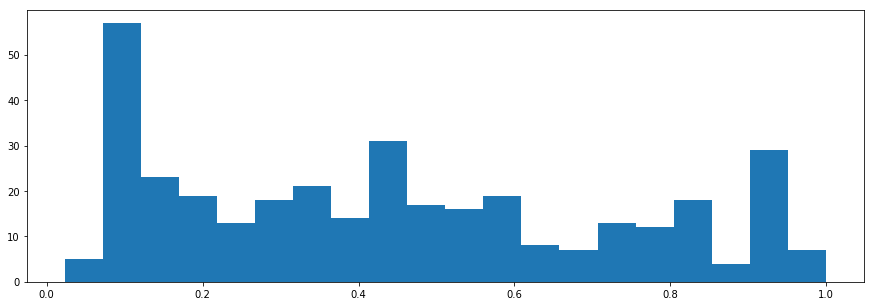

In [109]:
plt.hist(testcorrection[1], bins=20)

In [110]:
df240_scale.iloc[testcorrection[0]]

,WT_1,WT_2,WT_3,PPTC7_1,PPTC7_2,PPTC7_3,raw_pvals
Protein,,,,,,,
"sp|P24752|THIL_HUMAN Acetyl-CoA acetyltransferase, mitochondrial OS=Homo sapiens OX=9606 GN=ACAT1 PE=1 SV=1",0.410064,0.323005,0.448811,-0.049391,-0.048043,-0.008941,0.000406
"sp|P61604|CH10_HUMAN 10 kDa heat shock protein, mitochondrial OS=Homo sapiens OX=9606 GN=HSPE1 PE=1 SV=2",0.290653,0.290940,0.313515,-0.060768,-0.122350,-0.009878,0.000407
sp|P35232|PHB_HUMAN Prohibitin OS=Homo sapiens OX=9606 GN=PHB PE=1 SV=1,0.425272,0.403558,0.420897,0.056533,0.124531,0.094485,0.000098
"sp|O75390|CISY_HUMAN Citrate synthase, mitochondrial OS=Homo sapiens OX=9606 GN=CS PE=1 SV=2",0.553098,0.603067,0.546946,0.035703,-0.092388,-0.023056,0.000133


In [115]:
df240_scale['BH_cor_p'] = testcorrection[1]

In [116]:
df240_scale.iloc[178]

WT_1         0.115378
WT_2        -0.205522
WT_3         0.070070
PPTC7_1      0.897620
PPTC7_2      0.595151
PPTC7_3      0.849162
raw_pvals    0.004581
BH_cor_p     0.081324
Name: sp|P30084|ECHM_HUMAN Enoyl-CoA hydratase, mitochondrial OS=Homo sapiens OX=9606 GN=ECHS1 PE=1 SV=4, dtype: float64

In [117]:
df240_scale.iloc[180]

WT_1         0.061974
WT_2        -0.095904
WT_3        -0.514417
PPTC7_1     -0.135818
PPTC7_2     -0.706761
PPTC7_3     -0.518247
raw_pvals    0.322898
BH_cor_p     0.515170
Name: sp|O14734|ACOT8_HUMAN Acyl-coenzyme A thioesterase 8 OS=Homo sapiens OX=9606 GN=ACOT8 PE=1 SV=1, dtype: float64

In [118]:
df240_scale.index[0]

'sp|Q8WVM8|SCFD1_HUMAN Sec1 family domain-containing protein 1 OS=Homo sapiens OX=9606 GN=SCFD1 PE=1 SV=4'

# Add the peptides to the table

In [97]:
df240_scale.index

Index(['sp|Q8WVM8|SCFD1_HUMAN Sec1 family domain-containing protein 1 OS=Homo sapiens OX=9606 GN=SCFD1 PE=1 SV=4',
       'sp|P20674|COX5A_HUMAN Cytochrome c oxidase subunit 5A, mitochondrial OS=Homo sapiens OX=9606 GN=COX5A PE=1 SV=2',
       'sp|P09874|PARP1_HUMAN Poly [ADP-ribose] polymerase 1 OS=Homo sapiens OX=9606 GN=PARP1 PE=1 SV=4',
       'sp|Q96A35|RM24_HUMAN 39S ribosomal protein L24, mitochondrial OS=Homo sapiens OX=9606 GN=MRPL24 PE=1 SV=1',
       'sp|P25705|ATPA_HUMAN ATP synthase subunit alpha, mitochondrial OS=Homo sapiens OX=9606 GN=ATP5F1A PE=1 SV=1',
       'sp|P24752|THIL_HUMAN Acetyl-CoA acetyltransferase, mitochondrial OS=Homo sapiens OX=9606 GN=ACAT1 PE=1 SV=1',
       'sp|P23396|RS3_HUMAN 40S ribosomal protein S3 OS=Homo sapiens OX=9606 GN=RPS3 PE=1 SV=2',
       'sp|P36776|LONM_HUMAN Lon protease homolog, mitochondrial OS=Homo sapiens OX=9606 GN=LONP1 PE=1 SV=2',
       'sp|O00483|NDUA4_HUMAN Cytochrome c oxidase subunit NDUFA4 OS=Homo sapiens OX=9606 GN=NDUFA

In [99]:
prot

'sp|Q8WVM8|SCFD1_HUMAN Sec1 family domain-containing protein 1 OS=Homo sapiens OX=9606 GN=SCFD1 PE=1 SV=4'

In [102]:
qtargs2.index = qtargs2['Protein']

In [150]:
peptides = []
for prot in df240_scale.index:
    peptides.append(qtargs2.loc[prot]['Peptide'])
df240_scale['Peptide'] = peptides

In [151]:
peptides = []
for prot in df240.index:
    peptides.append(qtargs2.loc[prot]['Peptide'])
df240['Peptide'] = peptides
df240.head()

,WT_1,WT_2,WT_3,PPTC7_1,PPTC7_2,PPTC7_3,Peptide
Protein,,,,,,,
sp|Q8WVM8|SCFD1_HUMAN Sec1 family domain-containing protein 1 OS=Homo sapiens OX=9606 GN=SCFD1 PE=1 SV=4,0.621899,0.812120,0.960463,0.449424,1.434485,1.893385,A+42.01057AAAAATAAAAASIR
"sp|P20674|COX5A_HUMAN Cytochrome c oxidase subunit 5A, mitochondrial OS=Homo sapiens OX=9606 GN=COX5A PE=1 SV=2",0.930869,1.433395,1.646109,1.072225,1.126720,2.100397,GINTLVTYDMVPEPK
sp|P09874|PARP1_HUMAN Poly [ADP-ribose] polymerase 1 OS=Homo sapiens OX=9606 GN=PARP1 PE=1 SV=4,-0.949856,0.052858,0.669036,-1.230822,2.140713,1.885864,VVSEDFLQDVSASTK
"sp|Q96A35|RM24_HUMAN 39S ribosomal protein L24, mitochondrial OS=Homo sapiens OX=9606 GN=MRPL24 PE=1 SV=1",0.343304,1.105856,0.678051,-0.405727,0.278884,1.060528,NWVVVGGLNTHYR
"sp|P25705|ATPA_HUMAN ATP synthase subunit alpha, mitochondrial OS=Homo sapiens OX=9606 GN=ATP5F1A PE=1 SV=1",0.401157,1.022360,1.301175,0.098876,0.809569,1.849226,TSIAIDTIINQK


In [149]:
df240_scale.head()

,WT_1,WT_2,WT_3,PPTC7_1,PPTC7_2,PPTC7_3,raw_pvals,BH_cor_p,Peptide,MQ_log2FC,DI2A_log2FC
Protein,,,,,,,,,,,
sp|Q8WVM8|SCFD1_HUMAN Sec1 family domain-containing protein 1 OS=Homo sapiens OX=9606 GN=SCFD1 PE=1 SV=4,0.313720,0.013140,-0.063136,0.274077,0.369710,-0.038046,0.535754,0.704306,NaN,NaN,0.114006
"sp|P20674|COX5A_HUMAN Cytochrome c oxidase subunit 5A, mitochondrial OS=Homo sapiens OX=9606 GN=COX5A PE=1 SV=2",0.622690,0.634415,0.622509,0.896878,0.061945,0.168966,0.393515,0.577923,NaN,0.720735,-0.250608
sp|P09874|PARP1_HUMAN Poly [ADP-ribose] polymerase 1 OS=Homo sapiens OX=9606 GN=PARP1 PE=1 SV=4,-1.258035,-0.746122,-0.354564,-1.406169,1.075938,-0.045568,0.435658,0.606809,NaN,1.097683,0.660974
"sp|Q96A35|RM24_HUMAN 39S ribosomal protein L24, mitochondrial OS=Homo sapiens OX=9606 GN=MRPL24 PE=1 SV=1",0.035124,0.306876,-0.345549,-0.581074,-0.785891,-0.870904,0.023100,0.126687,NaN,NaN,-0.744774
"sp|P25705|ATPA_HUMAN ATP synthase subunit alpha, mitochondrial OS=Homo sapiens OX=9606 GN=ATP5F1A PE=1 SV=1",0.092978,0.223380,0.277576,-0.076470,-0.255206,-0.082205,0.013851,0.112161,NaN,NaN,-0.335939


# Write table 

In [139]:
df240.to_csv('P:/JGM_DI2A/Python/outputs/MITO/quant240k_unscaled_nonoise.csv', sep=',')

In [107]:
df240_scale.to_csv('P:/JGM_DI2A/Python/outputs/MITO/quant240k_require3_nonoise.csv', sep=',')

# Read in Skyline LC-MS SILAC quant from R

In [109]:
mq = pd.read_csv('P:/JGM_DI2A/R/outputs/mito/MQ_mito_peptide_stats.txt')
mq.head()

,L.H.norm.WT1,L.H.norm.WT2,L.H.norm.WT3,L.H.norm.PPTC7_1,L.H.norm.PPTC7_2,L.H.norm.PPTC7_3,pvals,bh,q,log2_pptc7_over_wt
AAAAAAAGDSDSWDADAFSVEDPVRK,0.323660,0.363512,0.660817,1.470089,0.702632,0.104589,0.491240,0.624917,0.222770,0.309774
AAAAAAALQAK,-0.335255,-0.299714,-0.547351,0.041016,0.313047,0.045997,0.011249,0.083923,0.029917,0.527460
AAAAAGTATSQR,0.300555,0.234669,0.132372,0.545677,0.983275,0.929666,0.015066,0.093264,0.033247,0.597007
AAAAAVGNAVPCGARPCGVRPDGQPK,0.995765,1.329667,1.178371,0.964151,1.581044,2.567981,0.323612,0.476514,0.169867,0.536458
AAAAELSLLEK,-0.045024,0.008798,-0.115699,0.154458,0.040230,0.106094,0.036815,0.142574,0.050825,0.150902


In [152]:
# try to match the peptides from DI2A to the mq index, take the ratio if found
di2a_pep_list = df240_scale['Peptide']
di2a_pep_list_cln = [re.sub('\+42.01057','', sequence) for sequence in di2a_pep_list]
di2a_pep_list_cln= [re.sub('\+57.0215','', sequence) for sequence in di2a_pep_list_cln]
di2a_pep_list_cln= [re.sub('\+15.9949','', sequence) for sequence in di2a_pep_list_cln]
di2a_pep_list_cln[0]

'AAAAAATAAAAASIR'

In [153]:
mq.loc[di2a_pep_list_cln[2]]['log2_pptc7_over_wt']

1.09768300100216

In [154]:
mq_log2FC = []
for i in range(0, len(di2a_pep_list_cln)):
    try:
        mq_log2FC.append(mq.loc[di2a_pep_list_cln[i]]['log2_pptc7_over_wt'])
    except:
        print('no match')
        mq_log2FC.append('NaN')

no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
n

In [155]:
mq_log2FC

['NaN',
 0.7207345760145191,
 1.09768300100216,
 'NaN',
 'NaN',
 -0.15217180147088097,
 0.6558241442504079,
 0.142802270472418,
 'NaN',
 -0.30289936132029305,
 'NaN',
 -0.262133366936785,
 'NaN',
 1.83279297420974,
 0.9038086258401079,
 'NaN',
 0.0501466109952272,
 -0.279841244925555,
 'NaN',
 0.7554705774568671,
 'NaN',
 'NaN',
 0.257971516199524,
 0.27021773840112195,
 'NaN',
 -0.0743260572252878,
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 -0.5066643466962371,
 0.5682355192904169,
 0.29686115987181394,
 1.47148441026121,
 'NaN',
 -0.0650158695268479,
 0.591970467592057,
 0.406258207570891,
 0.8882645593883071,
 -0.7370892748040899,
 0.29955607992366495,
 0.0346146792425921,
 'NaN',
 -0.08102735554721902,
 0.723626888752687,
 -0.611117760667266,
 'NaN',
 -0.13161961653508,
 'NaN',
 -0.00656213540478789,
 'NaN',
 0.0530530455684172,
 'NaN',
 0.31476191176922697,
 0.0124837136111691,
 'NaN',
 0.0993507696885804,
 -0.23785279228348497,
 -0.004134617577758629,
 0.15010825235080402,
 0.3701502813015

In [156]:
len(mq_log2FC)

351

In [157]:
len(di2a_pep_list_cln)

351

In [158]:
df240_scale['MQ_log2FC'] = mq_log2FC

In [159]:
df240_scale.head()

,WT_1,WT_2,WT_3,PPTC7_1,PPTC7_2,PPTC7_3,raw_pvals,BH_cor_p,Peptide,MQ_log2FC,DI2A_log2FC
Protein,,,,,,,,,,,
sp|Q8WVM8|SCFD1_HUMAN Sec1 family domain-containing protein 1 OS=Homo sapiens OX=9606 GN=SCFD1 PE=1 SV=4,0.313720,0.013140,-0.063136,0.274077,0.369710,-0.038046,0.535754,0.704306,A+42.01057AAAAATAAAAASIR,NaN,0.114006
"sp|P20674|COX5A_HUMAN Cytochrome c oxidase subunit 5A, mitochondrial OS=Homo sapiens OX=9606 GN=COX5A PE=1 SV=2",0.622690,0.634415,0.622509,0.896878,0.061945,0.168966,0.393515,0.577923,GINTLVTYDMVPEPK,0.720735,-0.250608
sp|P09874|PARP1_HUMAN Poly [ADP-ribose] polymerase 1 OS=Homo sapiens OX=9606 GN=PARP1 PE=1 SV=4,-1.258035,-0.746122,-0.354564,-1.406169,1.075938,-0.045568,0.435658,0.606809,VVSEDFLQDVSASTK,1.09768,0.660974
"sp|Q96A35|RM24_HUMAN 39S ribosomal protein L24, mitochondrial OS=Homo sapiens OX=9606 GN=MRPL24 PE=1 SV=1",0.035124,0.306876,-0.345549,-0.581074,-0.785891,-0.870904,0.023100,0.126687,NWVVVGGLNTHYR,NaN,-0.744774
"sp|P25705|ATPA_HUMAN ATP synthase subunit alpha, mitochondrial OS=Homo sapiens OX=9606 GN=ATP5F1A PE=1 SV=1",0.092978,0.223380,0.277576,-0.076470,-0.255206,-0.082205,0.013851,0.112161,TSIAIDTIINQK,NaN,-0.335939


In [160]:
# finally, compute the log2FC from the Di2a data
DI2A_log2FC = []
for i in range(0, len(df240_scale)):
    DI2A_log2FC.append(np.mean(df240_scale[pptc7_cols].iloc[i]) - np.mean(df240_scale[wt_cols].iloc[i]) )
df240_scale['DI2A_log2FC'] = DI2A_log2FC
#df240_scale['raw_pvals']

In [161]:
df240_scale.head()

,WT_1,WT_2,WT_3,PPTC7_1,PPTC7_2,PPTC7_3,raw_pvals,BH_cor_p,Peptide,MQ_log2FC,DI2A_log2FC
Protein,,,,,,,,,,,
sp|Q8WVM8|SCFD1_HUMAN Sec1 family domain-containing protein 1 OS=Homo sapiens OX=9606 GN=SCFD1 PE=1 SV=4,0.313720,0.013140,-0.063136,0.274077,0.369710,-0.038046,0.535754,0.704306,A+42.01057AAAAATAAAAASIR,NaN,0.114006
"sp|P20674|COX5A_HUMAN Cytochrome c oxidase subunit 5A, mitochondrial OS=Homo sapiens OX=9606 GN=COX5A PE=1 SV=2",0.622690,0.634415,0.622509,0.896878,0.061945,0.168966,0.393515,0.577923,GINTLVTYDMVPEPK,0.720735,-0.250608
sp|P09874|PARP1_HUMAN Poly [ADP-ribose] polymerase 1 OS=Homo sapiens OX=9606 GN=PARP1 PE=1 SV=4,-1.258035,-0.746122,-0.354564,-1.406169,1.075938,-0.045568,0.435658,0.606809,VVSEDFLQDVSASTK,1.09768,0.660974
"sp|Q96A35|RM24_HUMAN 39S ribosomal protein L24, mitochondrial OS=Homo sapiens OX=9606 GN=MRPL24 PE=1 SV=1",0.035124,0.306876,-0.345549,-0.581074,-0.785891,-0.870904,0.023100,0.126687,NWVVVGGLNTHYR,NaN,-0.744774
"sp|P25705|ATPA_HUMAN ATP synthase subunit alpha, mitochondrial OS=Homo sapiens OX=9606 GN=ATP5F1A PE=1 SV=1",0.092978,0.223380,0.277576,-0.076470,-0.255206,-0.082205,0.013851,0.112161,TSIAIDTIINQK,NaN,-0.335939


In [162]:
fc_cols = ['MQ_log2FC', 'DI2A_log2FC']

In [121]:
df240_scale2 = df240_scale.apply (pd.to_numeric, errors='coerce')
onlyfc = df240_scale2[fc_cols].dropna()
len(onlyfc)

202

In [122]:
fc_cols

['MQ_log2FC', 'DI2A_log2FC']

In [323]:
lim=3.5

3.5


Text(-3.25, 2.5, 'p-value=5.762e-59')

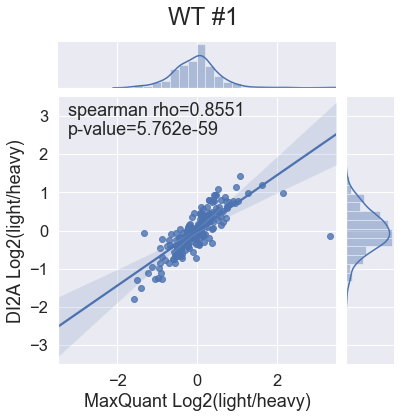

In [329]:
# get first value from WT1 MQ
mq_log2FC_wt1 = []
for i in range(0, len(di2a_pep_list_cln)):
    try:
        mq_log2FC_wt1.append(mq.loc[di2a_pep_list_cln[i]]['L.H.norm.WT1'])
    except:
        #print('no match')
        mq_log2FC_wt1.append('NaN')
wt1df = pd.DataFrame(df240_scale['WT_1'], index=df240.index)
wt1df['MQ_WT_1'] = mq_log2FC_wt1
wt1df = wt1df.apply (pd.to_numeric, errors='coerce')
wt1df = wt1df.dropna()
#lim = np.abs(wt1df).max().max()+0.1
g = sns.jointplot(wt1df['MQ_WT_1'], wt1df["WT_1"], xlim=[-lim,lim], ylim=[-lim, lim], kind='reg')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('WT #1', fontsize=24) # can also get the figure from plt.gcf()
plt.xlabel('MaxQuant Log2(light/heavy)')
plt.ylabel('DI2A Log2(light/heavy)')
print(lim)
#sns.legend()
plt.text(-lim+0.25, lim-0.5, 'spearman rho='+str(round(spearmanr(wt1df['MQ_WT_1'], wt1df["WT_1"])[0], 4)) )
plt.text(-lim+0.25, lim-1, 'p-value='+'{:0.3e}'.format(spearmanr(wt1df['MQ_WT_1'], wt1df["WT_1"])[1])) 

#spearmanr(wt1df['MQ_WT_1'], wt1df["WT_1"])

3.5


Text(-3.25, 2.5, 'p-value=1.349e-54')

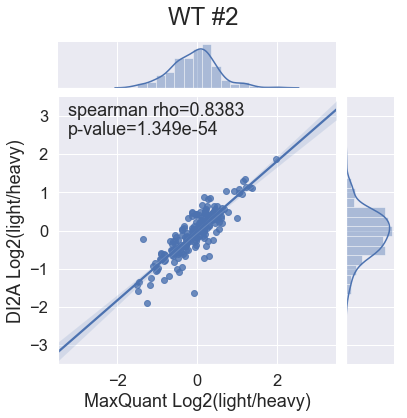

In [330]:
# get first value from WT1 MQ
mq_log2FC_wt1 = []
for i in range(0, len(di2a_pep_list_cln)):
    try:
        mq_log2FC_wt1.append(mq.loc[di2a_pep_list_cln[i]]['L.H.norm.WT2'])
    except:
        #print('no match')
        mq_log2FC_wt1.append('NaN')
wt1df = pd.DataFrame(df240_scale['WT_2'], index=df240.index)
wt1df['MQ_WT_2'] = mq_log2FC_wt1
wt1df = wt1df.apply (pd.to_numeric, errors='coerce')
wt1df = wt1df.dropna()
#lim = np.abs(wt1df).max().max()+0.1
g = sns.jointplot(wt1df['MQ_WT_2'], wt1df["WT_2"], xlim=[-lim,lim], ylim=[-lim, lim], kind='reg')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('WT #2', fontsize=24) # can also get the figure from plt.gcf()
plt.xlabel('MaxQuant Log2(light/heavy)')
plt.ylabel('DI2A Log2(light/heavy)')
print(lim)
plt.text(-lim+0.25, lim-0.5, 'spearman rho='+str(round(spearmanr(wt1df['MQ_WT_2'], wt1df["WT_2"])[0], 4)) )
plt.text(-lim+0.25, lim-1, 'p-value='+'{:0.3e}'.format(spearmanr(wt1df['MQ_WT_2'], wt1df["WT_2"])[1])) 

3.5


Text(-3.25, 2.5, 'p-value=1.351e-61')

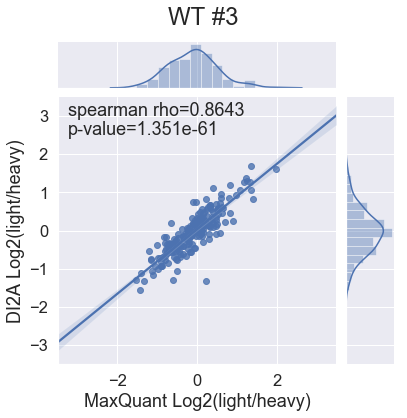

In [331]:
# get first value from WT1 MQ
mq_log2FC_wt1 = []
for i in range(0, len(di2a_pep_list_cln)):
    try:
        mq_log2FC_wt1.append(mq.loc[di2a_pep_list_cln[i]]['L.H.norm.WT3'])
    except:
        #print('no match')
        mq_log2FC_wt1.append('NaN')
wt1df = pd.DataFrame(df240_scale['WT_3'], index=df240.index)
wt1df['MQ_WT_3'] = mq_log2FC_wt1
wt1df = wt1df.apply (pd.to_numeric, errors='coerce')
wt1df = wt1df.dropna()
#lim = np.abs(wt1df).max().max()+0.1
g = sns.jointplot(wt1df['MQ_WT_3'], wt1df["WT_3"], xlim=[-lim,lim], ylim=[-lim, lim], kind='reg')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('WT #3', fontsize=24) # can also get the figure from plt.gcf()
plt.xlabel('MaxQuant Log2(light/heavy)')
plt.ylabel('DI2A Log2(light/heavy)')
print(lim)
plt.text(-lim+0.25, lim-0.5, 'spearman rho='+str(round(spearmanr(wt1df['MQ_WT_3'], wt1df["WT_3"])[0], 4)) )
plt.text(-lim+0.25, lim-1, 'p-value='+'{:0.3e}'.format(spearmanr(wt1df['MQ_WT_3'], wt1df["WT_3"])[1])) 